In [1]:
from __future__ import print_function

from scipy.stats import norm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Lambda
from keras.layers import Dropout
from keras.objectives import binary_crossentropy
import keras.backend as K
from keras import metrics

from keras.callbacks import TensorBoard, ModelCheckpoint
from time import time
import h5py

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# fijo la semilla aleatoria por reproducibilidad
np.random.seed(7)

C:\Users\roberto\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data = pd.read_csv("D:/MBIT-2017-18-Master-Deep-Learning/Reto QMENTA - Junio 2018/ADHD-200/adhd200_preprocessed.csv",sep=';', encoding='latin-1')
data.head()

,ScanDir ID,Site,Gender,Age,Handedness,DX,Secondary Dx,ADHD Measure,ADHD Index,Inattentive,Hyper/Impulsive,IQ Measure,Verbal IQ,Performance IQ,Full2 IQ,Full4 IQ,Med Status,QC_Athena,QC_NIAK
0,2371032,3,0,10.73,1.0,0,NaN,2,47.0,55.0,43.0,1,121,119,NaN,122,1,1.0,1.0
1,2026113,3,0,12.99,1.0,1,NaN,2,90.0,89.0,78.0,1,122,108,NaN,106,1,1.0,1.0
2,3434578,3,0,8.12,1.0,0,NaN,2,42.0,42.0,43.0,1,85,98,NaN,89,1,1.0,1.0
3,8628223,3,0,10.81,1.0,0,Simple phobia,2,42.0,49.0,49.0,1,85,86,NaN,97,1,1.0,1.0
4,1623716,3,0,12.65,1.0,1,NaN,2,87.0,90.0,90.0,1,89,88,NaN,89,1,1.0,1.0


In [3]:
ID                     = data['ScanDir ID'].as_matrix()
Gender                 = data['Gender'].as_matrix()
Age                    = data['Age'].as_matrix()
Handedness             = data['Handedness'].as_matrix()
ADHDMeasure            = data['ADHD Measure'].as_matrix()
ADHD                   = data['ADHD Index'].as_matrix()
Inattentive            = data['Inattentive'].as_matrix()
HyperImpulsive         = data['Hyper/Impulsive'].as_matrix()
IQMeasure              = data['IQ Measure'].as_matrix()
VerbalIQ               = data['Verbal IQ'].as_matrix()
PerformanceIQ          = data['Performance IQ'].as_matrix()
Full4IQ                = data['Full4 IQ'].as_matrix()

In [4]:
ID.shape

(504,)

In [5]:
x_data = data.iloc[0:,[2,3,4,7,8,9,10,11,12,13,15]]
x_data.shape

(504, 11)

In [6]:
original_dim = x_data.shape[1]
latent_dim = 2
intermediate_dim = 256
epsilon_std = 1.0

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean)

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 11)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          3072        input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

C:\Users\roberto\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Output "dense_5" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_5" during training.


In [7]:
x_train, x_test = train_test_split(x_data, test_size=0.25, random_state=42)
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
print(x_train.shape)  

(378, 11)


In [8]:
LOAD_MODEL = False
batch_size = 64
epochs = 500
filepath="autoencoder_vae_ADHD_best.h5" 

if not LOAD_MODEL:
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                                     save_best_only=True,
                                     mode='min') # graba sólo los que mejoran en validación
    
    callbacks_list = [checkpoint]
    
    vae.fit(x_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            callbacks = callbacks_list,
            verbose=0,
            validation_data=(x_test, None))


Epoch 00001: val_loss improved from inf to 6.47062, saving model to autoencoder_vae_ADHD_best.h5

Epoch 00002: val_loss improved from 6.47062 to 5.55079, saving model to autoencoder_vae_ADHD_best.h5

Epoch 00003: val_loss improved from 5.55079 to 4.42042, saving model to autoencoder_vae_ADHD_best.h5

Epoch 00004: val_loss improved from 4.42042 to 2.54862, saving model to autoencoder_vae_ADHD_best.h5

Epoch 00005: val_loss improved from 2.54862 to 0.98185, saving model to autoencoder_vae_ADHD_best.h5

Epoch 00006: val_loss improved from 0.98185 to -0.58792, saving model to autoencoder_vae_ADHD_best.h5

Epoch 00007: val_loss improved from -0.58792 to -2.77540, saving model to autoencoder_vae_ADHD_best.h5

Epoch 00008: val_loss improved from -2.77540 to -6.28307, saving model to autoencoder_vae_ADHD_best.h5

Epoch 00009: val_loss improved from -6.28307 to -9.84163, saving model to autoencoder_vae_ADHD_best.h5

Epoch 00010: val_loss improved from -9.84163 to -14.19968, saving model to aut


Epoch 00103: val_loss did not improve

Epoch 00104: val_loss did not improve

Epoch 00105: val_loss did not improve

Epoch 00106: val_loss did not improve

Epoch 00107: val_loss did not improve

Epoch 00108: val_loss did not improve

Epoch 00109: val_loss did not improve

Epoch 00110: val_loss did not improve

Epoch 00111: val_loss did not improve

Epoch 00112: val_loss improved from -55.70486 to -55.71285, saving model to autoencoder_vae_ADHD_best.h5

Epoch 00113: val_loss did not improve

Epoch 00114: val_loss did not improve

Epoch 00115: val_loss did not improve

Epoch 00116: val_loss improved from -55.71285 to -55.97808, saving model to autoencoder_vae_ADHD_best.h5

Epoch 00117: val_loss did not improve

Epoch 00118: val_loss improved from -55.97808 to -56.42843, saving model to autoencoder_vae_ADHD_best.h5

Epoch 00119: val_loss did not improve

Epoch 00120: val_loss did not improve

Epoch 00121: val_loss did not improve

Epoch 00122: val_loss did not improve

Epoch 00123: val_l


Epoch 00286: val_loss did not improve

Epoch 00287: val_loss improved from -59.82282 to -59.85222, saving model to autoencoder_vae_ADHD_best.h5

Epoch 00288: val_loss did not improve

Epoch 00289: val_loss did not improve

Epoch 00290: val_loss did not improve

Epoch 00291: val_loss did not improve

Epoch 00292: val_loss did not improve

Epoch 00293: val_loss did not improve

Epoch 00294: val_loss did not improve

Epoch 00295: val_loss did not improve

Epoch 00296: val_loss did not improve

Epoch 00297: val_loss improved from -59.85222 to -59.98775, saving model to autoencoder_vae_ADHD_best.h5

Epoch 00298: val_loss did not improve

Epoch 00299: val_loss improved from -59.98775 to -59.99672, saving model to autoencoder_vae_ADHD_best.h5

Epoch 00300: val_loss did not improve

Epoch 00301: val_loss did not improve

Epoch 00302: val_loss did not improve

Epoch 00303: val_loss did not improve

Epoch 00304: val_loss did not improve

Epoch 00305: val_loss did not improve

Epoch 00306: val_l

In [9]:
encoder = Model(x, z_mean)

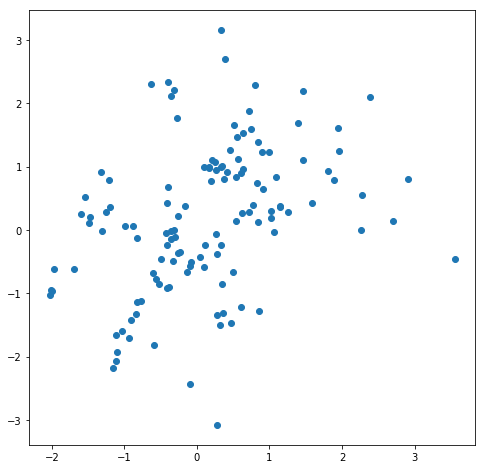

In [10]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(8, 8))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1])
plt.show()

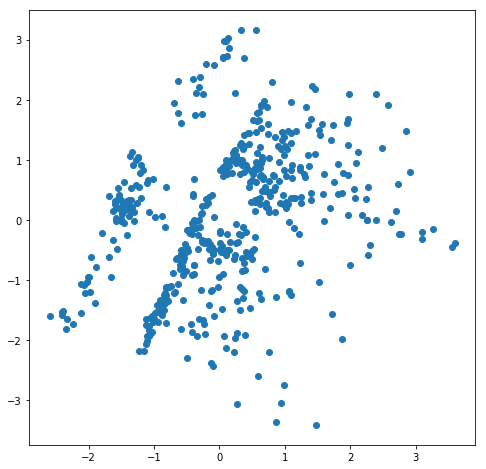

In [11]:
client = scaler.transform(x_data)
client_rep_latente = encoder.predict(client, batch_size=batch_size)
plt.figure(figsize=(8, 8))
plt.scatter(client_rep_latente[:, 0], client_rep_latente[:, 1])
plt.show()

In [12]:
print(data.shape)
print(client_rep_latente.shape)
print(client_rep_latente[0:5,])

(504, 19)
(504, 2)
[[-0.48858514 -0.4629947 ]
 [-1.9106401  -1.3776441 ]
 [-1.5967855   0.25603446]
 [-1.4838161   0.22607805]
 [-2.3293896  -1.6504761 ]]


In [13]:
data_client = np.hstack((data, client_rep_latente))
print(data_client.shape)

(504, 21)


Text(0.5,1,'Elbow curve')

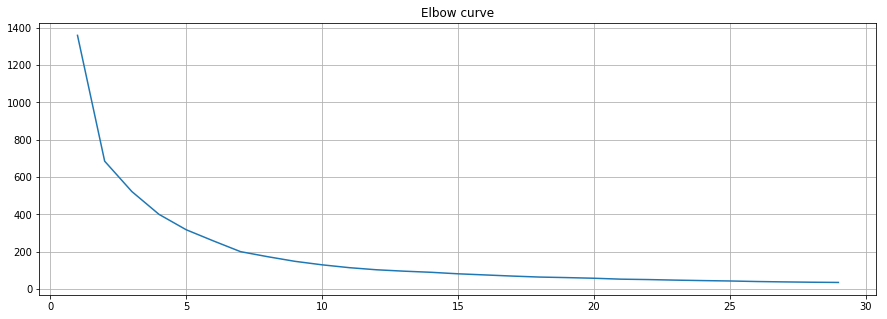

In [14]:
from sklearn.cluster import KMeans

distorsions = []
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(client_rep_latente)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 30), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [23]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(client_rep_latente)
num_cluster = (kmeans.labels_.reshape(client_rep_latente.shape[0],1)) + 1
print(num_cluster)

[[2]
 [3]
 [4]
 [4]
 [3]
 [2]
 [2]
 [2]
 [3]
 [4]
 [2]
 [2]
 [4]
 [2]
 [4]
 [2]
 [3]
 [2]
 [2]
 [2]
 [4]
 [4]
 [4]
 [4]
 [2]
 [2]
 [3]
 [2]
 [2]
 [2]
 [2]
 [4]
 [2]
 [2]
 [2]
 [2]
 [4]
 [4]
 [4]
 [2]
 [2]
 [4]
 [4]
 [2]
 [2]
 [3]
 [2]
 [2]
 [4]
 [4]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [4]
 [2]
 [2]
 [2]
 [3]
 [4]
 [4]
 [2]
 [2]
 [3]
 [3]
 [2]
 [3]
 [4]
 [4]
 [3]
 [2]
 [6]
 [3]
 [2]
 [2]
 [2]
 [3]
 [4]
 [2]
 [2]
 [3]
 [2]
 [2]
 [4]
 [3]
 [2]
 [2]
 [2]
 [3]
 [3]
 [3]
 [2]
 [4]
 [3]
 [2]
 [4]
 [4]
 [2]
 [3]
 [4]
 [3]
 [2]
 [2]
 [2]
 [3]
 [2]
 [3]
 [2]
 [3]
 [3]
 [3]
 [3]
 [3]
 [4]
 [2]
 [3]
 [3]
 [3]
 [3]
 [4]
 [2]
 [3]
 [2]
 [3]
 [4]
 [2]
 [3]
 [4]
 [4]
 [4]
 [2]
 [2]
 [2]
 [3]
 [2]
 [4]
 [3]
 [3]
 [4]
 [2]
 [4]
 [3]
 [2]
 [4]
 [2]
 [2]
 [4]
 [2]
 [4]
 [3]
 [2]
 [2]
 [4]
 [4]
 [3]
 [3]
 [4]
 [4]
 [3]
 [4]
 [2]
 [3]
 [2]
 [3]
 [3]
 [1]
 [2]
 [2]
 [3]
 [4]
 [2]
 [3]
 [2]
 [2]
 [4]
 [3]
 [4]
 [4]
 [3]
 [2]
 [3]
 [3]
 [1]
 [4]
 [4]
 [3]
 [3]
 [3]
 [2]
 [2]
 [3]
 [2]
 [6]
 [2]
 [2]
 [2]
 [3]
 [3]


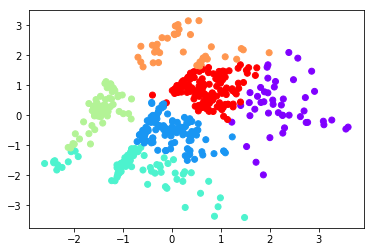

In [24]:
plt.scatter(client_rep_latente[:,0],client_rep_latente[:,1], c=kmeans.labels_, cmap='rainbow') 

In [25]:
data["cluster"] = num_cluster
data["latente-x"] = client_rep_latente[:,0]
data["latente-y"] = client_rep_latente[:,1]   

In [26]:
data.head() 

,ScanDir ID,Site,Gender,Age,Handedness,DX,Secondary Dx,ADHD Measure,ADHD Index,Inattentive,...,Verbal IQ,Performance IQ,Full2 IQ,Full4 IQ,Med Status,QC_Athena,QC_NIAK,cluster,latente-x,latente-y
0,2371032,3,0,10.73,1.0,0,NaN,2,47.0,55.0,...,121,119,NaN,122,1,1.0,1.0,2,-0.488585,-0.462995
1,2026113,3,0,12.99,1.0,1,NaN,2,90.0,89.0,...,122,108,NaN,106,1,1.0,1.0,3,-1.910640,-1.377644
2,3434578,3,0,8.12,1.0,0,NaN,2,42.0,42.0,...,85,98,NaN,89,1,1.0,1.0,4,-1.596786,0.256034
3,8628223,3,0,10.81,1.0,0,Simple phobia,2,42.0,49.0,...,85,86,NaN,97,1,1.0,1.0,4,-1.483816,0.226078
4,1623716,3,0,12.65,1.0,1,NaN,2,87.0,90.0,...,89,88,NaN,89,1,1.0,1.0,3,-2.329390,-1.650476


In [27]:
data.to_csv("D:/MBIT-2017-18-Master-Deep-Learning/Reto QMENTA - Junio 2018/ADHD-200/cluster-ADHD-autoencoder-vae-6-cluster.csv",sep=';',decimal=',')
    